# Simulated Annealing

1. Introduzione
2. Iperparametri
    - Dimensione mossa ($\epsilon$)
    - Temperatura iniziale e fattore di raffreddamento ($T_0$ e $ \alpha$)
    - Bound
3. Risultati
    - MNIST
    - Fashion-MNIST
    - CIFAR10

## 1. Introduzione

Alcuni import e funzioni di supporto per il notebook.

In [1]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import random as rm
import numpy as np
import time
import copy
import math

# Add the sibling folders
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
import src.utils as ut

# Plot libraries and tables
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import glob

In [3]:
def read_folder(folder):    
    results = {}
    for filename in glob.glob(f'{folder}/*.npz'):
        filename_filtered = '.'.join(filename.split("/")[-1].split(".")[0:-1])
        results.update({filename_filtered: np.load(filename)})
    return results

In [11]:
def generate_move(epsilon):
    h = torch.tensor([], dtype=torch.float32).cuda()
    for k, param in enumerate(net.parameters()):
        tensor_size = param.data.size()
        move = torch.zeros(tensor_size).cuda()
        move.normal_(std=epsilon)
        h = torch.cat((h, move.view(-1)), dim=-1)
    return h.tolist()

Come descritto nella mail iniziale ad ogni iterazione vengono valutate entrambe le possibile mosse $ w \pm \epsilon \Delta(w) $. Se una delle due mosse decresce la funzione obiettivo, viene accettata la migliore, altrimenti si utilizza la formula di Simulated Annealing per decidere se accettare o meno. L'implementazione finale è qui presentata.

L'algoritmo nella sua versione stocastica utilizza lo stesso epsilon e la stessa temperatura per una epoca. Ad ogni conclusione vengono aggiornati $ \epsilon $ e temperatura.
- $ \epsilon $ viene ridotto di un fattore 10 solo se in un'epoca vi sono un numero insufficiente di mosse migliorative, ovvero
\begin{align} \frac{num\_mosse\_migliorative}{num\_mosse\_totali} < bound   \end{align}
Questo per raggiungere l'effetto di annealing di $ \epsilon $
- la temperatura viene moltiplicata per un fattore di raffreddamento  $ \alpha $ ($ 0 < \alpha < 1$)

In [5]:
def stochastic_simulated_annealing(trainloader, model, epsilon, T, gpu=True):
    model.train()
    
    not_accepted, accepted = 0, 0
    probabilities = []
    
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        if gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        initial_loss = ut.test_minibatch(inputs, labels, model)[0]
        
        # List used to keep the move to get back to the initial point
        inverse = []

        # First move
        for param in model.parameters():
            # Replicate the tensor
            tensor_size = param.data.size()
            move = torch.zeros(tensor_size)
            # Send it to the GPU
            if gpu:
                move = move.cuda()
            # Generate move
            move.normal_(std=epsilon)
            # Step back is saved
            inverse.append(move.mul(-1)) 
            # Move the parameters
            param.data.add_(move)
        # Evaluate the loss 
        first_loss = ut.test_minibatch(inputs, labels, model)[0]

        # Second move
        for k, param in enumerate(model.parameters()):
            param.data.add_(inverse[k].mul(2))
            inverse[k].mul_(-1)
        second_loss = ut.test_minibatch(inputs, labels, model)[0]

        # Get back if the first move is better
        if first_loss < second_loss:
            for k, param in enumerate(model.parameters()):
                param.data.add_(inverse[k].mul(2))
                inverse[k].mul_(-1)
            new_loss = first_loss
        else: new_loss = second_loss
        
        if new_loss > initial_loss:
            probabilities.append(math.exp(- (new_loss - initial_loss) / T))
        
        # Reject worse solution according to the standard formula
        if new_loss > initial_loss and math.exp(- (new_loss - initial_loss) / T) < rm.random():
            not_accepted += 1
            for k, param in enumerate(model.parameters()):
                param.data.add_(inverse[k])
            new_loss = initial_loss
        elif new_loss > initial_loss:
            accepted += 1
        
        del move, inverse, inputs, labels
        
    return not_accepted, accepted, probabilities

## 2. Parametri

### Dimensioni mossa
La mossa viene generata tramite distribuzione normale. Per capire la dimensione corretta è utile confrontare la distribuzione del gradiente con la distribuzione della mossa random di SA.
Un esempio di come viene generata una mossa random $ \Delta(w) $.

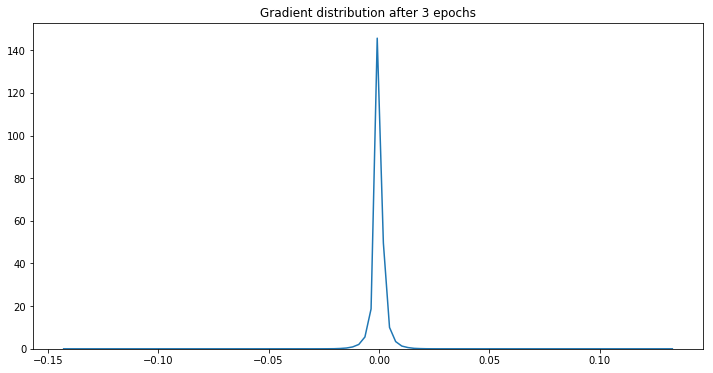

In [21]:
net = ut.load_net(net='convnet', dataset_name='fashion-mnist').cuda()
g = torch.tensor([], dtype=torch.float32).cuda()

train_loader, test_loader = ut.load_dataset(dataset_name='fashion-mnist', minibatch=512, drop_last=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
for epoch in range(2):
    ut.train(train_loader, net, optimizer, criterion, 1)

for k, param in enumerate(net.parameters()):
    g = torch.cat((g, param.grad.data.clone().view(-1)), dim=-1)

fig, ax = plt.subplots(figsize=(12, 6))
gradient = g.tolist()

plt.title('Gradient distribution after 3 epochs')
sns.distplot(gradient, hist=False)
plt.show()

In [22]:
e3 = generate_move(1e-3)
e4 = generate_move(1e-4)
e5 = generate_move(1e-5)

# Scale the gradient
grad = [g * 0.01 for g in gradient]

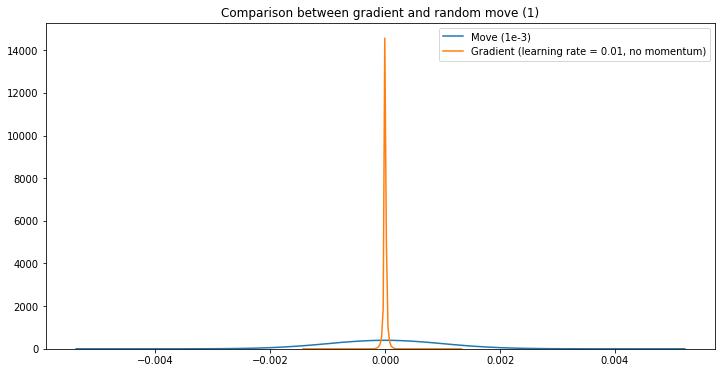

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Comparison between gradient and random move (1)')
sns.distplot(e3, hist=False, label='Move (1e-3)')
sns.distplot(grad, hist=False, label='Gradient (learning rate = 0.01, no momentum)')
plt.legend()
plt.show()

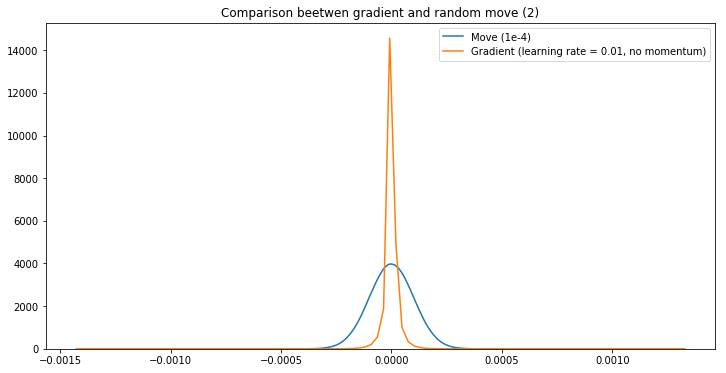

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Comparison beetwen gradient and random move (2)')
sns.distplot(e4, hist=False, label='Move (1e-4)')
sns.distplot(grad, hist=False, label='Gradient (learning rate = 0.01, no momentum)')
plt.legend()
plt.show()

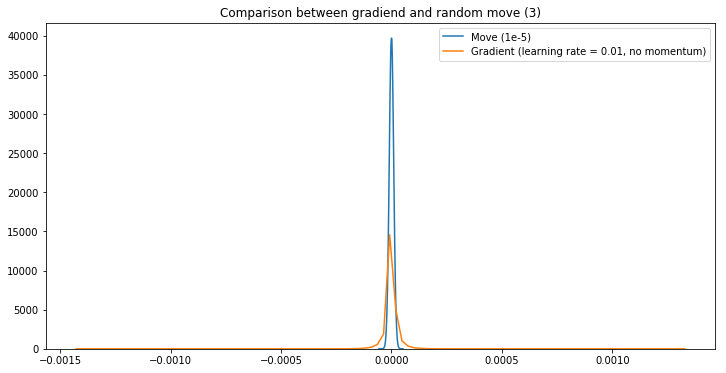

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.title('Comparison between gradiend and random move (3)')
sns.distplot(e5, hist=False, label='Move (1e-5)')
sns.distplot(grad, hist=False, label='Gradient (learning rate = 0.01, no momentum)')
plt.legend()
plt.show()

Nei test svolti ho notato che utlizzare una mossa con valori più ampi (1e-3) su determinati dataset permette di velocizzare l'allenamento nelle prime epoche, ma tende rapidamente ad effetti oscillatori. Dunque ho svolto tutti i test facendo partire da 1e-3 per poi diminuire automaticamente.
Forzare lo stesso valore di $\epsilon$ porta ad effetti peggiorativi dopo poche epoche. Un esempio nel grafico precedente, dove già alla 15esima epoca la funzione obiettivo inizia a crescere.

In [26]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/epsilon_costante')
fig, ax = plt.subplots(figsize=(12,6))
for name, result in results.items():
    n_epochs = 20
    ax.plot(np.arange(0, n_epochs), result['train_loss'][0:n_epochs], '--', label='Train')
    ax.plot(np.arange(0, n_epochs), result['validation_loss'][0:n_epochs], '--', label='Validation')
ax.legend()
plt.title('Loss with fixed epsilon=1e-3')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
mpld3.display()

### Bound
Quando le mosse peggiorative diventano eccessive $\epsilon$ viene diminuito. Un esempio di come avviene il drop di $\epsilon$: la barra verticale rossa delimita il passaggio da $\epsilon=0.001$ a  $\epsilon=0.0001$

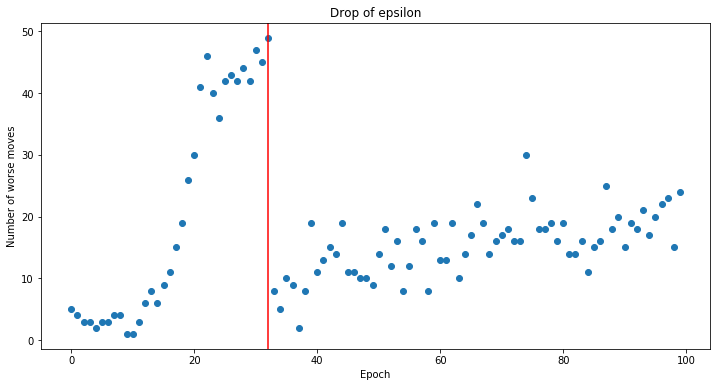

In [29]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/run__2019-01-28_14:24:33')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    drop_eps = result['drop_eps'][()]
    
    n_epochs = 100
    na = result['na']
    ac = result['ac']
    ax.scatter(np.arange(0, n_epochs), np.asarray(na)[0:n_epochs] + np.asarray(ac)[0:n_epochs])
    for drop in drop_eps.keys():
        plt.axvline(x=drop, color='red')

plt.xlabel('Epoch')
plt.ylabel('Number of worse moves')
plt.title('Drop of epsilon')
plt.show()

Diversi valori sono testati per trovare il migliore tradeoff che minimizzasse velocità di training.

In [6]:
results = read_folder('../../results/SSA/mnist/convnet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    n_epochs = len(result['train_loss'])
    ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label=name)

plt.title('Bound comparison (ConvNet on MNIST)')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
ax.legend()

mpld3.display()

Si può notare come utilizzare delle soglie basse, quindi più restrittive porti a non diminuire $\epsilon$, generando effetti oscillatori che erano stati individuati anche nel grafico 'Loss with fixed epsilon 1e-3'. Seppur nelle prime epoche sia maggiormente veloce, rapidamente si presentano effetti peggiorativi. Un valore di $0.5$ sembra raggiungere la migliore performance tra velocità e accuratezza. Un valore del bound pari a 0.7, seppure più lento raggiunge le stesse performance.

### Temperatura iniziale e fattore di raffreddamento
La funzione di annealing è stata studiata per dividere approssitivamente le mille epoche a metà tra diversificazione e intensificazione. Nei test $ T_O $ è sempre stato posto ad 1, mentre $ \alpha $ pari a 0.97 per un lento raffreddamento. Considerando che un solo ciclo è stato utilizzato e che il numero di epoche è piuttosto elevato, il fattore di normalizzazione non è stato necessario. Un esempio di distribuzione delle probabilità per ogni iterazione nel grafico seguente.

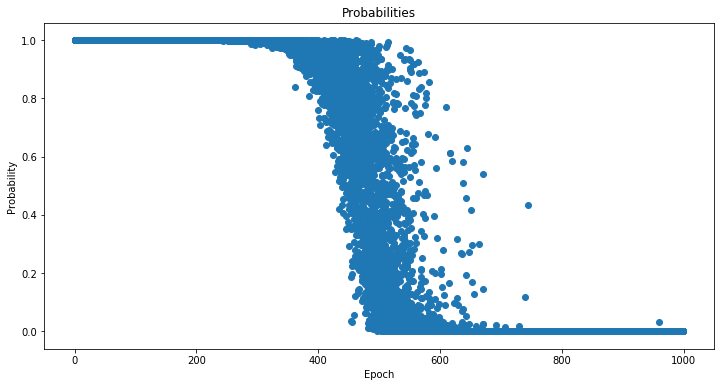

In [7]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/run__2019-01-28_14:24:33')
fig, ax = plt.subplots(figsize=(12,6))
for name, result in results.items():
    probabilities = result['probabilities'][()]
    x, y = zip(*((k, float(x)) for k in probabilities for x in probabilities[k]))
    n_epochs = len(result['train_accuracy'])
    ax.scatter(x, y, label=name)
plt.title('Probabilities')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.show()

Un esempio che raggruppa tutto. Si noti che la barra verticale rossa delimita il drop di $\epsilon$.

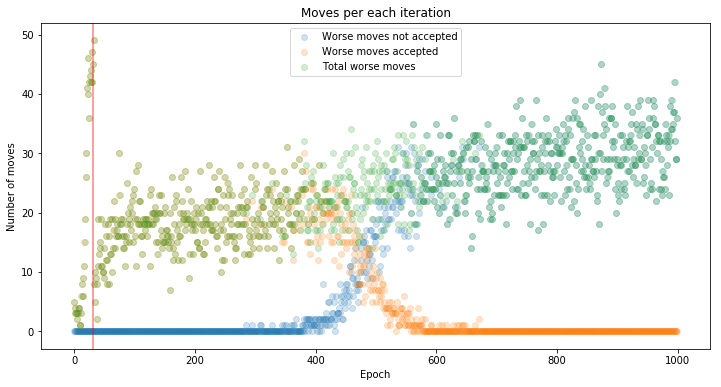

In [35]:
results = read_folder('../../results/SSA/fashion-mnist/vgg16/run__2019-01-28_14:24:33')
fig, ax = plt.subplots(figsize=(12, 6))

for name, result in results.items():
    drop_eps = result['drop_eps'][()]
    na = result['na']
    ac = result['ac']

    ax.scatter(np.arange(0, len(na)) - 0.1, na, label='Worse moves not accepted', alpha=0.2)
    ax.scatter(np.arange(0, len(ac)), ac, label='Worse moves accepted', alpha=0.2)
    ax.scatter(np.arange(0, len(na)) + 0.1, np.asarray(na) + np.asarray(ac), label='Total worse moves', alpha=0.2)

    for drop in drop_eps.keys():
        plt.axvline(x=drop - 1, color='red', alpha=0.5)

ax.legend()
plt.title('Moves per each iteration')
plt.xlabel('Epoch')
plt.ylabel('Number of moves')
plt.show()


## 3. Risultati

### MNIST

I risultati che le avevo già mandato su una rete convoluzionale a due livelli + due livelli lineari. Essendo un dataset piuttosto semplice, non ho svolto test con altre reti.

In [33]:
results = read_folder('../../results/SSA/mnist/convnet/SSAvsSGDonConvNet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    n_epochs = len(result['train_loss'])
    ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label=name+' train')
    ax.plot(np.arange(0, n_epochs), result['validation_loss'], '--', label=name+' validation')

    #plt.axvline(x=9, color='red', alpha=0.2)
plt.title('Loss comparison')
plt.xlabel('Epochs')
ax.legend()
mpld3.display()

In [37]:
results = read_folder('../../results/SSA/mnist/convnet/SSAvsSGDonConvNet')
fig, ax = plt.subplots(figsize=(12, 6))
for name, result in results.items():
    n_epochs = len(result['train_accuracy'])
    ax.plot(np.arange(0, n_epochs), result['train_accuracy'], '--', label=name+' train')
    ax.plot(np.arange(0, n_epochs), result['train_accuracy'], '--', label=name+' validation')

    #plt.axvline(x=9, color='red', alpha=0.2)
plt.title('Accuracy comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax.legend()
mpld3.display()

### Fashion-MNIST

### CIFAR10